In [14]:
# This magic makes plots appear 
%matplotlib notebook
%matplotlib inline
import numpy as np
# Load Firedrake on Colab
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake
from firedrake.petsc import PETSc
import matplotlib.pyplot as plt

# 2-D Cylindrical Case
## Weak formulation<br>
For our reference we take another look at our weak formulation:<br>

$$\int_\Omega (\nabla \vec{v})\colon \mu \left[ \nabla \vec{u} + \left( \nabla \vec{u} \right)^T\right] \ dx 
 - \int_{\Omega} \left( \nabla \cdot \vec{v}\right)\ p \ dx
 - \int_{\Omega} Ra_0\ T\ \vec{v}\cdot\hat{k} \ dx = 0 \ \text{ for all } v\in V,$$

$$ \int_\Omega w \nabla \cdot \vec{u} \ dx\ \text{ for all } v\in V,$$

$$  \int_\Omega q\frac{\partial T}{\partial t} \ dx
  + \int_\Omega q \vec{u}\cdot \nabla T \ dx 
  + \int_\Omega \left(\nabla q\right) \cdot \left(\kappa \nabla T\right) \ dx = 0   \text{ for all } q\in Q.$$

Note that we have integrated by parts the viscosity and pressure gradient terms in the Stokes equations, and the diffusion term in the energy equation, but have omitted the corresponding boundary terms. Our goal in this section is to examine simulations in a 2-D cylindrical domain.<br> 

We define our domain by the radii of the inner ($r_{\text{min}}$) and outer ($r_{\text{max}}$) boundaries. These are chosen such that the non--dimensional depth of the mantle,
$z = r_{\text{max}} - r_{\text{min}} = 1$, and the ratio of the inner and outer radii, $f=r_{\text{min}} / r_{\text{max}} = 0.55$, thus approximating the ratio between the
radii of Earth's surface and core-mantle-boundary (CMB). Specifically, we set $r_{\text{min}} = 1.22$ and $r_{\text{max}} = 2.22$.<br>




In [15]:
from firedrake import *
from mpi4py import MPI
# Quadrature degree for our integrals:
dx = dx(degree=6)

# Set up geometry:
rmin, rmax, ncells, nlayers = 1.22, 2.22, 32, 8

# Function to generate a cylindrical mesh
# cylinder_mesh is replacing the following 
#mesh1d = CircleManifoldMesh(ncells, radius=rmin, degree=2)
#mesh = ExtrudedMesh(mesh1d, layers=nlayers, extrusion_type='radial')
def cylinder_mesh(rmin, rmax, ncells, nlayers):
    cmesh = CylinderMesh(ncells, nlayers, quadrilateral=True)
    coord_fs = VectorFunctionSpace(cmesh, FiniteElement("Q", 'quadrilateral', 1, variant="equispaced"), dim=2)
    new_coords = Function(coord_fs)
    new_coords.dat.data[:] = cmesh.coordinates.dat.data[:,:2] * (rmin + cmesh.coordinates.dat.data[:,2][:,np.newaxis] * (rmax-rmin))
    mesh = Mesh(new_coords)
    new_coords2 = Function(VectorFunctionSpace(mesh, "CG", 2))
    new_coords2.interpolate(SpatialCoordinate(mesh))
    x, y = SpatialCoordinate(mesh)
    rlin = interpolate(sqrt(x**2 + y**2), FunctionSpace(mesh, "CG", 1))
    new_coords2.interpolate(new_coords2/sqrt(new_coords2[0]**2 + new_coords2[1]**2) * rlin)
    return Mesh(new_coords2)


# generating mesh
mesh = cylinder_mesh(rmin, rmax, ncells, nlayers)
bottom_id, top_id = 1, 2 # the ids for the bottom surface and the top one 
n = FacetNormal(mesh)  # Normals, required for Nusselt number calculation
domain_volume = assemble(1*dx(domain=mesh))  # Required for diagnostics (e.g. RMS velocity)
top_surface = assemble(Constant(1, domain=mesh)*ds(1))
bottom_surface = assemble(Constant(1, domain=mesh)*ds(2))

### Exercise 7.1:
- Visualise the generated mesh.

- Change radial and lateral resolution and visualise the mesh again. 


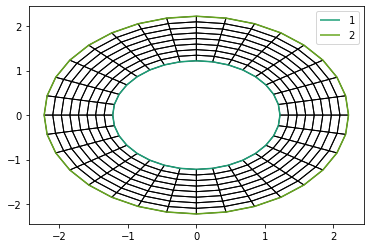

In [16]:
fig, axes = plt.subplots()
triplot(mesh, axes=axes)
axes.legend();

We now need the function spaces that are associated with this mesh. We follow the same definitions as our last exercise, and use the following definitions: 


In [17]:
# Set up function spaces - currently using the bilinear Q2Q1 element pair:
V = VectorFunctionSpace(mesh, "CG", 2)  # Velocity function space (vector)
W = FunctionSpace(mesh, "CG", 1)  # Pressure function space (scalar)
Q = FunctionSpace(mesh, "CG", 2)  # Temperature function space (scalar)
Z = MixedFunctionSpace([V, W])  # Mixed function space.
# Test functions and functions to hold solutions:
v, w = TestFunctions(Z)
q = TestFunction(Q)
z = Function(Z)  # a field over the mixed function space Z.
u, p = split(z)  # Returns symbolic UFL expression for u and p


We choose the initial temperature distribution in a way so that our convection run produces 4 equidistant plumes. This initial temperature field is prescribed as:
$$T(x,y) = (r_{\text{max}} - r) + A\cos(4 \; atan2\ (y,x))  \sin(r-r_{\text{min}}) \pi)$$
where $A=0.02$ is the amplitude of the initial perturbation. 

In [18]:
# Set up temperature field and initialise:
X = SpatialCoordinate(mesh)
r = sqrt(X[0]**2 + X[1]**2)
Told, Tnew = Function(Q, name="OldTemp"), Function(Q, name="NewTemp");
pi = 3.141592653589793238
Told.interpolate(rmax - r + 0.02*cos(4*atan_2(X[1], X[0])) * sin((r - rmin) * pi))
Tnew.assign(Told)

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x12571fb50>, FiniteElement('Q', quadrilateral, 2), name=None), Mesh(VectorElement(FiniteElement('Q', quadrilateral, 2), dim=2), 31)), 78)

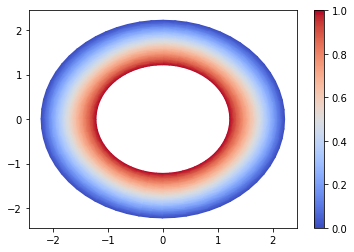

In [19]:
# Let's visualise the initial temperature field now
# NBVAL_IGNORE_OUTPUT
fig, axes = plt.subplots()
collection = tripcolor(Tnew, axes=axes, cmap='coolwarm')
fig.colorbar(collection);

Next, we strategise our solutions for the energy equations. We use $\theta$ time-stepping scheme for our enery solutions, and define our way of computing a time step consistent with a cfl condition number of 1.0.

In [20]:
# Temporal discretisation - Using a Crank-Nicholson scheme where theta = 0.5:
Ttheta = 0.5*Tnew + (1 - 0.5)*Told

# Define time stepping parameters:
steady_state_tolerance = 1e-9
max_timesteps = 2000 
target_cfl_no = 1.0
maximum_timestep = 0.1
increase_tolerance = 1.5
time = 0.0

# Timestepping - CFL related stuff:
ref_vel = Function(V, name="Reference_Velocity")

def compute_timestep(u, current_delta_t):
    """Return the timestep, based upon the CFL criterion"""

    ref_vel.interpolate(dot(JacobianInverse(mesh), u))
    ts_min = 1. / mesh.comm.allreduce(ref_vel.dat.data.max(), MPI.MAX)
    # Grab (smallest) maximum permitted on all cores:
    ts_max = min(float(current_delta_t) * increase_tolerance, maximum_timestep)
    # Compute timestep:
    tstep = min(ts_min * target_cfl_no, ts_max)
    return tstep

### Setting Solve Parameters - An iterative approach
Although direct solves provide robust performance in small problems, in 3-D and large problems, the computational (CPU and memory) requirements quickly become intractable. PETSc's `fieldsplit pc_type` provides a class of preconditioners for mixed problems that allows one to apply different preconditioners to different blocks of the system. Here we configure the Schur complement approach (see GMD paper for more info) 
    
The `fieldsplit_0` entries configure solver options for the first of these blocks, the $K$ matrix. The linear systems associated with this matrix are solved using a combination of the Conjugate Gradient method (`cg`, line 10) and an algebraic multigrid preconditioner (`gamg`, line 15). We also specify two options (`gamg_threshold` and `gamg_square_graph`) that control the aggregation method (coarsening strategy) in the GAMG preconditioner, which balance the multigrid effectiveness (convergence rate) with coarse grid complexity (cost per iteration).<br>

`fieldsplit_1` contains solver options for the Schur complement solve. Here we approxmiate the Schur complement matrix with a mass matrix scaled by viscosity, which is implementd in `MassInvPC`, with the viscosity provided through the option `apptcx` (Line 29 of a few cells below).

 Specification of the matrix type `matfree` (line 3) for the combined system ensures that we do not explicitly assemble its associated sparse matrix, instead computing the matrix-vector multiplications required by the Krylov iterations as they arise. Again, for preconditioning in the $K$-matrix solve we need access to matrix values, which is achieved using `AssembledPC`. This explicitly assembles the $K$-matrix by extracting relevant terms from the `F_Stokes` form.

Finally, the energy solve is performed through a combination of the GMRES (`gmres`) Krylov method and SSOR preconditioning (lines 27). For all iterative solves we specify a convergence criterion based on the relative reduction of the preconditioned residual (`ksp_rtol`).

In [21]:
# Stokes Equation Solver Parameters:
stokes_solver_parameters = {
    "mat_type": "matfree",
    "snes_type": "ksponly",
    "ksp_type": "preonly",
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "schur",
    "pc_fieldsplit_schur_type": "full",
    "fieldsplit_0": {
        "ksp_type": "cg",
        "ksp_rtol": 1e-5,
        #"ksp_converged_reason": None,
        "pc_type": "python",
        "pc_python_type": "firedrake.AssembledPC",
        "assembled_pc_type": "gamg",
        "assembled_pc_gamg_threshold": 0.01,
        "assembled_pc_gamg_square_graph": 100,
    },
    "fieldsplit_1": {
        "ksp_type": "fgmres",
        "ksp_rtol": 1e-4,
        #"ksp_converged_reason": None,
        "pc_type": "python",
        "pc_python_type": "firedrake.MassInvPC",
        "Mp_ksp_rtol": 1e-5,
        "Mp_ksp_type": "cg",
        "Mp_pc_type": "sor",
    }
}

# Energy Equation Solver Parameters:
energy_solver_parameters = {
    "mat_type": "aij",
    "snes_type": "ksponly",
    "ksp_type": "gmres",
    "ksp_rtol": 1e-5,
    #"ksp_converged_reason": None,
    "pc_type": "sor",
}

## Boundary Condition: Introducting Weak Imposition of Boundary Conditions
Boundary conditions for temperature are $T = 0$ at the surface ($r_{\text{max}}$) and $T = 1$ at the base ($r_{\text{min}}$).<br>
For velocity boundary conditions we choose free‐slip velocity boundary conditions that are specified on both boundaries. We incorporate these <b>weakly</b> through the <i>Nitsche</i> approximation.
### Weak Imposition of Boudary Conditions - Nitsche Penalty Method
In curved domains, such as the 2-D cylindrical and 3-D spherical cases examined below, imposing free-slip boundary conditions 
is complicated by the fact that it is not straightforward to decompose the degrees of freedom of the velocity space V
into tangential and lateral components for many finite element discretisations. For Lagrangian based discretisations we could
define normal vectors at the Lagrangian nodes on the surface and decompose accordingly, but these normal vectors would have
to be averaged due to the piecewise approximation of the curved surface. To avoid such complications for our examples in
cylindrical and spherical geometries, we employ <i>a symmetric Nitsche penalty method</i>  where the velocity space
is not restricted and, thus, retains all discrete solutions with a non-zero normal component.<br>

This entails adding the following three surface integrals:
\begin{equation}
  - \int_{\partial\Omega} \vec{v}\cdot\vec{n}~
    \vec{n}\cdot \left(\mu \left[\nabla\vec{u}
    + \left(\nabla\vec{u}\right)^T\right]\right)\cdot \vec{n} \ ds
  - \int_{\partial\Omega} 
    \vec{n}\cdot \left(\mu \left[\nabla\vec{v}
    + \left(\nabla\vec{v}\right)^T\right]\right)\cdot \vec{n}~
    \vec{u}\cdot\vec{n} \ ds
  + \int_{\partial\Omega} C_{\text{Nitsche}} \, \mu \vec{v}\cdot\vec{n} ~ \vec
  u\cdot\vec{n} \ ds .
\end{equation}


The first of these corresponds to the normal component of stress 
associated with integration by parts of the viscosity term. The tangential
component, as before, is omitted and weakly imposes a zero shear stress
condition. The second term ensures symmetry of Equation \eqref{eq:weak_mom} 
with respect to $\vec{u}$ and $\vec{v}$. The third term penalizes the normal
component of $\vec{u}$ and involves a penalty parameter $C_{\text{Nitsche}}>0$
that should be sufficiently large to ensure convergence.

<br>
coercivity of the bilinear form $F_{\text{Stokes}}$ introduced in
Lower bounds for $C_{\text{Nitsche},f}$ on each face $f$ can be derived for simplicial \citep{shahbazi_2005} and quadrilateral/hexahedral \citep{hillewaert_2013} meshes

Finally for the energy equation, we apply a simple $\theta$ scheme 

In [22]:

# Stokes related constants (note that since these are included in UFL, they are wrapped inside Constant):
Ra = Constant(1e5)  # Rayleigh number
mu = Constant(1.0)  # Viscosity
k = as_vector((X[0], X[1])) / r
C_ip = Constant(100.0)  # Fudge factor for interior penalty term used in weak imposition of BCs
p_ip = 2  # Maximum polynomial degree of the _gradient_ of velocity

# Temperature equation related constants:
delta_t = Constant(1e-7)  # Initial time-step
kappa = Constant(1.0)  # Thermal diffusivity

# Stokes equations in UFL form:
def stress(u):
    return 2 * mu * sym(grad(u))
# EXCERSIE 7.2 & 7.3
F_stokes = inner(grad(v), stress(u)) * dx - div(v) * p * dx + dot(n, v) * p * (ds(top_id)+ds(bottom_id)) - (dot(v, k) * Ra * Ttheta) * dx
F_stokes += -w * div(u) * dx + w * dot(n, u) * (ds(top_id)+ds(bottom_id))  # Continuity equation

# nitsche free-slip BCs
F_stokes += -dot(v, n) * dot(dot(n, stress(u)), n) * (ds(top_id)+ds(bottom_id))
F_stokes += -dot(u, n) * dot(dot(n, stress(v)), n) * (ds(top_id)+ds(bottom_id))
F_stokes += C_ip * mu * (p_ip + 1)**2 * FacetArea(mesh) / CellVolume(mesh) * dot(u, n) * dot(v, n) * (ds(top_id)+ds(bottom_id))

# Energy equation in UFL form:
F_energy = q * (Tnew - Told) / delta_t * dx + q * dot(u, grad(Ttheta)) * dx + dot(grad(q), kappa * grad(Ttheta)) * dx

# Temperature boundary conditions
bctb, bctt = DirichletBC(Q, 1.0, bottom_id), DirichletBC(Q, 0.0, top_id)
#bcvt = DirichletBC(Z.sub(0), Constant((0,0)), top_id)


### Nullspaces and near-nullspaces 
With a free-slip boundary condition on both boundaries, one can add an arbitrary rotation of the form $(-y, x)=r\hat{\mathbf{\theta}}$ to the velocity solution (i.e. this case incorporates a velocity nullspace, as well as a pressure nullspace). These lead to null-modes (eigenvectors) for the linear system, rendering the resulting matrix singular. In preconditioned Krylov methods these null-modes must be subtracted from the approximate solution at every iteration.

By using the GAMG preconditioner, we must provide near-nullspace information for the GAMG preconditioner, consisting of three rotational (`x_rotV`, `y_rotV`, `z_rotV`) and three translational (`nns_x`, `nns_y`, `nns_z`) modes (see GMD paper for details). 

We now update the Stokes problem to account for additional boundary conditions, and the Stokes solver to include the near nullspace options defined above, in addition to the optional `appctx` keyword argument that passes the viscosity through to our `MassInvPC` Schur complement preconditioner. Energy solver options are also updated relative to our base case, using the dictionary that is created before.


In [23]:

# Nullspaces and near-nullspaces:
x_rotV = Function(V).interpolate(as_vector((-X[1], X[0])))
V_nullspace = VectorSpaceBasis([x_rotV])
V_nullspace.orthonormalize()
p_nullspace = VectorSpaceBasis(constant=True)  # Constant nullspace for pressure n
Z_nullspace = MixedVectorSpaceBasis(Z, [Z.sub(0), p_nullspace])  # Setting mixed nullspace

# Generating near_nullspaces for GAMG:
nns_x = Function(V).interpolate(Constant([1., 0.]))
nns_y = Function(V).interpolate(Constant([0., 1.]))
V_near_nullspace = VectorSpaceBasis([nns_x, nns_y, x_rotV])
V_near_nullspace.orthonormalize()
Z_near_nullspace = MixedVectorSpaceBasis(Z, [V_near_nullspace, Z.sub(1)])

# To access functions with their appropriate names
u, p = z.split()  # Do this first to extract individual velocity and pressure fields.
# Next rename for output:
u.rename("Velocity")
p.rename("Pressure")

# Setup problem and solver objects so we can reuse (cache) solver setup
stokes_problem = NonlinearVariationalProblem(F_stokes, z) #, bcs=[bcvt]) # velocity BC's handled through Nitsche
#stokes_problem = NonlinearVariationalProblem(F_stokes, z, bcs=[bcvt]) # velocity BC's handled through Nitsche
stokes_solver = NonlinearVariationalSolver(
    stokes_problem,
    solver_parameters=stokes_solver_parameters,
    appctx={"mu": mu},
    nullspace=Z_nullspace,
    transpose_nullspace=Z_nullspace,
    near_nullspace=Z_near_nullspace
)
energy_problem = NonlinearVariationalProblem(F_energy, Tnew, bcs=[bctb, bctt])
energy_solver = NonlinearVariationalSolver(energy_problem, solver_parameters=energy_solver_parameters)


NameError: name 'bcvt' is not defined

### Main time stepping
We can now initiate the time-loop, with the Stokes system solved seperately. These `solve` calls once again convert symbolic mathematics into computation. In the time loop, set here to run until we reach a steady-state (see `maxchange`), we compute the RMS velocity and surface Nusselt number for diagnostic purposes, and print these results every 50 timesteps. 

In [ ]:
# Now perform the time loop:
for timestep in range(0, max_timesteps):

    current_delta_t = delta_t
    if timestep != 0:
        delta_t.assign(compute_timestep(u, current_delta_t))  # Compute adaptive time-step
    time += float(delta_t)

    # Solve Stokes sytem:
    stokes_solver.solve()

    # Temperature system:
    energy_solver.solve()

    # Compute diagnostics:
    u_rms = sqrt(assemble(dot(u, u) * dx)) * sqrt(1./domain_volume)
    f_ratio = rmin/rmax
    top_scaling = -1.3290170684486309  # log(f_ratio) / (1.- f_ratio)
    bot_scaling = -0.7303607313096079  # (f_ratio * log(f_ratio)) / (1.- f_ratio)
    nusselt_number_top = (assemble(dot(grad(Tnew), n) * ds(top_id)) / assemble(Constant(1.0, domain=mesh)*ds(top_id))) * top_scaling
    nusselt_number_base = (assemble(dot(grad(Tnew), n) * ds(bottom_id)) / assemble(Constant(1.0, domain=mesh)*ds(bottom_id))) * bot_scaling
    energy_conservation = abs(abs(nusselt_number_top) - abs(nusselt_number_base))
    average_temperature = assemble(Tnew * dx) / domain_volume

    # Calculate L2-norm of change in temperature:
    maxchange = sqrt(assemble((Tnew - Told)**2 * dx))

    if timestep % 100 == 0 or maxchange < steady_state_tolerance:
        PETSc.Sys.Print(f"u_rms={u_rms}, Nu_t={nusselt_number_top}, Nu_b={nusselt_number_base}, maxchange={maxchange}")

    # Leave if steady-state has been achieved:
    if maxchange < steady_state_tolerance:
        log("Steady-state achieved -- exiting time-step loop")
        break

    # Set Told = Tnew - assign the values of Tnew to Told
    Told.assign(Tnew)

In [ ]:
# Let's visualise the initial temperature field now
# NBVAL_IGNORE_OUTPUT
fig, axes = plt.subplots()
collection = tripcolor(Tnew, axes=axes, cmap='coolwarm')
fig.colorbar(collection);

### Exercise 7.2
- Change the top boundary conditions from free-slip to no-slip (zero velocity) in the following script. The appropriate boundary condition can be set by using `DirichletBC`. Notice the change in `nullspaces` for this problem. 